In [1]:
import gpflow
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (24, 6)
plt = matplotlib.pyplot

/home/staff1/ctorney/python3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


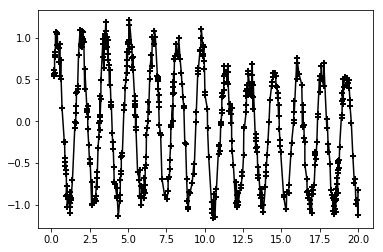

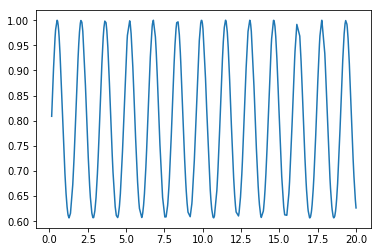

In [2]:
N = 500
X = 20*np.random.rand(N,1)
X=np.sort(X,axis=0)
Y = (-0.2/(1+np.exp(-(X-10)*10)))+(1-0.2/(1+np.exp(-(X-10)*10)))*np.sin(2*3.142*X/1.57) + np.random.randn(N,1)*0.1 
plt.plot(X, Y, 'k-+', mew=2)
plt.show()
x1=0.5
p=1.57
ls=1
r = np.pi * (X - x1) / p
r=(np.sin(r))**2/ls 
r = np.exp(-0.5 * r)
plt.plot(X,r)
plt.show()


In [3]:
k1 = gpflow.kernels.Matern52(1, lengthscales=0.3)
k = gpflow.kernels.Periodic(1,period=1.57, variance=1.0, lengthscales=1.0)

M=500
Z = X[::M, :].copy()
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 1.0

/home/staff1/ctorney/python3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


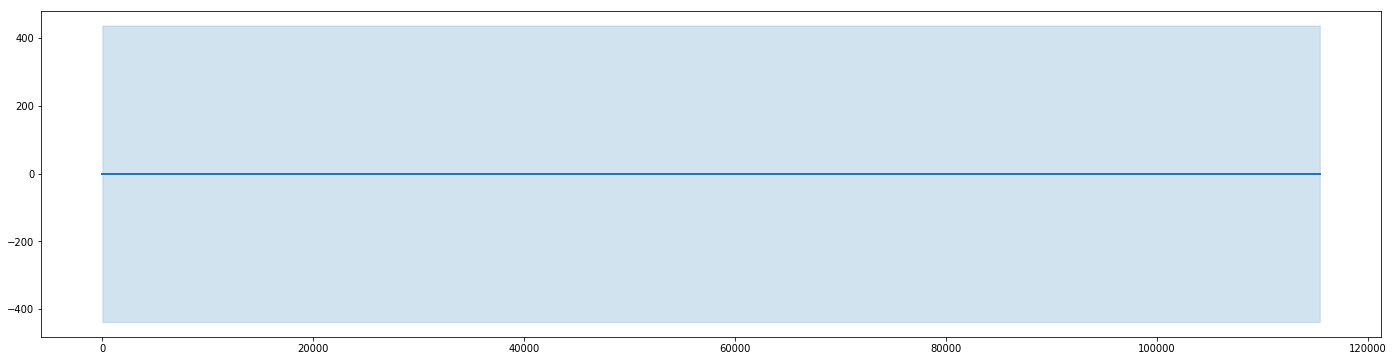

In [89]:
def plot(m):
    xx = np.linspace(-0.1, max(X), 1000).reshape(1000, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(24, 6))
    #plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    #plt.xlim(-0.1, 10.1)
    
plot(m)

In [2]:
import tensorflow as tf
from functools import reduce
    
class ChangePoint(gpflow.kernels.Combination):
    def __init__(self, kern_list, offset, variance):
        super(ChangePoint, self).__init__(kern_list)
        self.offset = gpflow.Param(offset)
        self.variance = gpflow.Param(variance)


    def K(self, X, X2=None, presliced=False):
        # assert len(self.kern_list) != 3, "has to have two kernels only"
        if X2 is None:
            X2 = X
        #XXT = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X, axis=1), tf.expand_dims(X, axis=2))) + self.offset
        #XXT2 = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X2, axis=1), tf.expand_dims(X2, axis=2))) + self.offset
        XXT = self.variance * tf.squeeze(X-self.offset)
        XXT2 = self.variance *tf.squeeze(tf.transpose(X2)-self.offset)
        sigm = tf.sigmoid(XXT)
        sigm2 = tf.sigmoid(XXT2)
        sig1 = tf.matmul(tf.expand_dims(sigm, axis=1),
                         tf.expand_dims(sigm2, axis=0))
        sig2 = tf.matmul(tf.expand_dims((1. - sigm), axis=1),
                         tf.expand_dims((1. - sigm2), axis=0))
        a1 = reduce(tf.multiply,
                    [sig1, self.kernels[0].K(X, X2)])
        a2 = reduce(tf.multiply,
                    [sig2, self.kernels[1].K(X, X2)])
        return reduce(tf.add, [a1, a2])


    def Kdiag(self, X, presliced=False):
        # assert len(self.kern_list) != 3, "has to have two kernels only"
        #XXT = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X, axis=1), tf.expand_dims(X, axis=2))) + self.offset
        XXT = self.variance * tf.squeeze(X-self.offset)

        sigm = tf.sigmoid(XXT)
        a1 = reduce(tf.multiply, [sigm, self.kernels[0].Kdiag(X),
                             sigm])
        a2 = reduce(tf.multiply, [(1. - sigm), self.kernels[1].Kdiag(X),
                             1. - sigm])
        return reduce(tf.add, [a1, a2])

/home/staff1/ctorney/python3/lib/python3.6/site-packages/gpflow/logdensities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -410.637274
  Number of iterations: 112
  Number of functions evaluations: 134


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/kernels/0/variance,Parameter,None,+ve,True,(),True,11.636368389464607
GPR/kern/kernels/0/lengthscales,Parameter,None,+ve,True,(),True,4.678558887312815
GPR/kern/kernels/0/period,Parameter,None,+ve,True,(),True,1.5683855998864171
GPR/kern/kernels/1/variance,Parameter,None,+ve,True,(),True,12.537681289064189
GPR/kern/kernels/1/lengthscales,Parameter,None,+ve,True,(),True,4.162777424561964
GPR/kern/kernels/1/period,Parameter,None,+ve,True,(),True,1.5711668619736767
GPR/kern/offset,Parameter,None,(none),True,(),True,9.97174979828301
GPR/kern/variance,Parameter,None,(none),True,(),True,69.31699227156834
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.009959739862124855


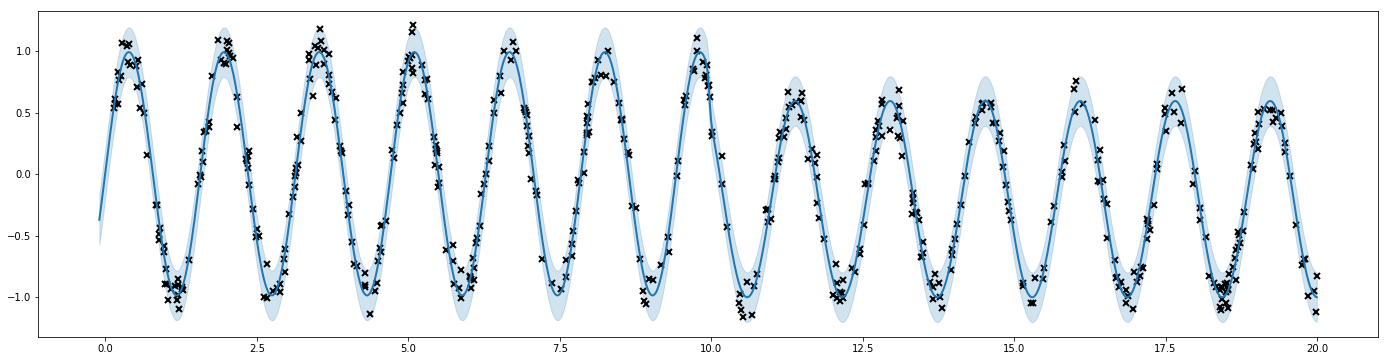

In [8]:
k1 = gpflow.kernels.Matern52(1, lengthscales=0.3)
k1 = gpflow.kernels.Periodic(1,period=1.57, variance=1.0, lengthscales=1.0)
k2 = gpflow.kernels.Periodic(1,period=1.57, variance=1.0, lengthscales=1.0)
k=ChangePoint([k1,k2],offset=10.0,variance=1.0)
m = gpflow.models.GPR(X, Y, kern=k)
m.likelihood.variance = 1.0
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
#plt.plot(X, Y, 'kx', mew=2)
m.as_pandas_table()

In [3]:

import pandas as pd
import numpy as np

import math

import datetime
import matplotlib.pyplot as plt

import scipy.ndimage as sp
        

posfilename = 'clean_data.csv'

posDF = pd.read_csv(posfilename) 

X = posDF['Y'].values
Y = posDF['X'].values
dates = posDF['DATE'].values.copy()
t = np.zeros(len(dates))

import datetime
strdate =posDF['DATE'].min()
sdate = datetime.datetime.strptime(strdate, "%Y-%m-%d %H:%M:%S")

for i in range(len(t)):
    dt1 = datetime.datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
    delta =  (dt1 - sdate).total_seconds() / datetime.timedelta(days=1).total_seconds()
    t[i]=delta
    
X = X.reshape(len(X), 1)
Y = Y.reshape(len(Y), 1)
t = t.reshape(len(t), 1)

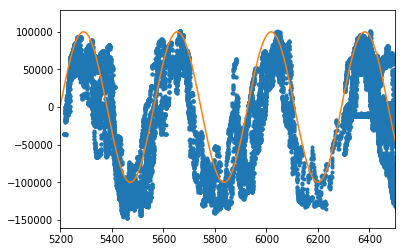

In [100]:
plt.plot(t[::1],X[::1],'.')
t2 = np.arange(5200,7500)
plt.plot(t2, 100000*np.sin(2*3.142*(t2-100)/364.25))
plt.xlim(5200,6500)
plt.show()

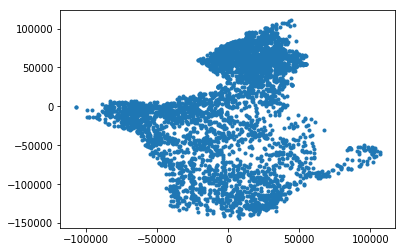

In [84]:
plt.plot(Y[::10],X[::10],'.')

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1833048.891771
  Number of iterations: 64
  Number of functions evaluations: 124


,class,prior,transform,trainable,shape,fixed_shape,value
SGPR/kern/variance,Parameter,None,+ve,True,(),True,2929217.9324567067
SGPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.000492830665045e-06
SGPR/kern/period,Parameter,None,+ve,True,(),True,350.69360837857977
SGPR/likelihood/variance,Parameter,None,+ve,True,(),True,80357819.16633542
SGPR/feature/Z,Parameter,None,(none),True,"(102, 1)",True,"[[-831184.0448316529], [-54071.75708729126], [..."


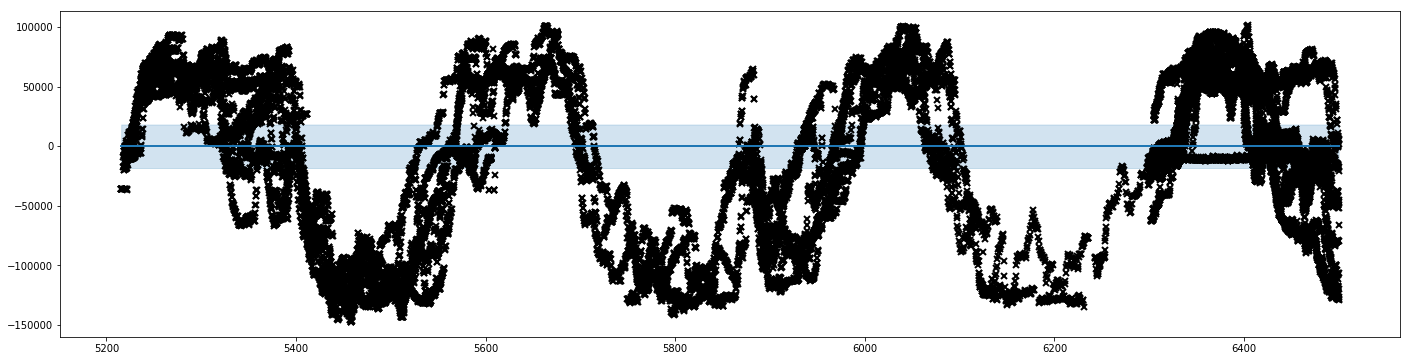

In [7]:
k1 = gpflow.kernels.Matern52(1, lengthscales=0.3)
k1 = gpflow.kernels.Periodic(1,period=364.25, variance=1.0, lengthscales=1.0)
k2 = gpflow.kernels.Periodic(1,period=1.57, variance=1.0, lengthscales=1.0)
k=ChangePoint([k1,k2],offset=10.0,variance=1.0)

X = X.reshape(len(X), 1)
t = t.reshape(len(t), 1)

M=500
Z = X[::M, :].copy()
m = gpflow.models.SGPR(t, X, kern=k1,Z=Z)
m.likelihood.variance = 1.0
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
#plt.plot(X, Y, 'kx', mew=2)
m.as_pandas_table()

In [5]:
T1 = t[(t>00)&(t<6500)]

X1 = X[(t>00)&(t<6500)]/100000
X1 = X1.reshape(len(X1),1)
Y1 = Y[(t>00)&(t<6500)]/100000
Y1 = Y1.reshape(len(Y1),1)

T1 = T1.reshape(len(T1),1)

def plot(m):
    xx = np.linspace(min(T1), max(T1), 1000).reshape(1000, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(24, 6))
    plt.plot(T1, X1, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    #plt.xlim(-0.1, 10.1)
    


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 15965.576514
  Number of iterations: 53
  Number of functions evaluations: 111


,class,prior,transform,trainable,shape,fixed_shape,value
SGPR/kern/variance,Parameter,None,+ve,True,(),True,419.414458235549
SGPR/kern/lengthscales,Parameter,None,+ve,True,(),True,0.2594019024459849
SGPR/kern/period,Parameter,None,+ve,False,(),True,364.25
SGPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.12686193727294912
SGPR/feature/Z,Parameter,None,(none),True,"(82, 1)",True,"[[5217.449887330136], [5243.483510417975], [52..."


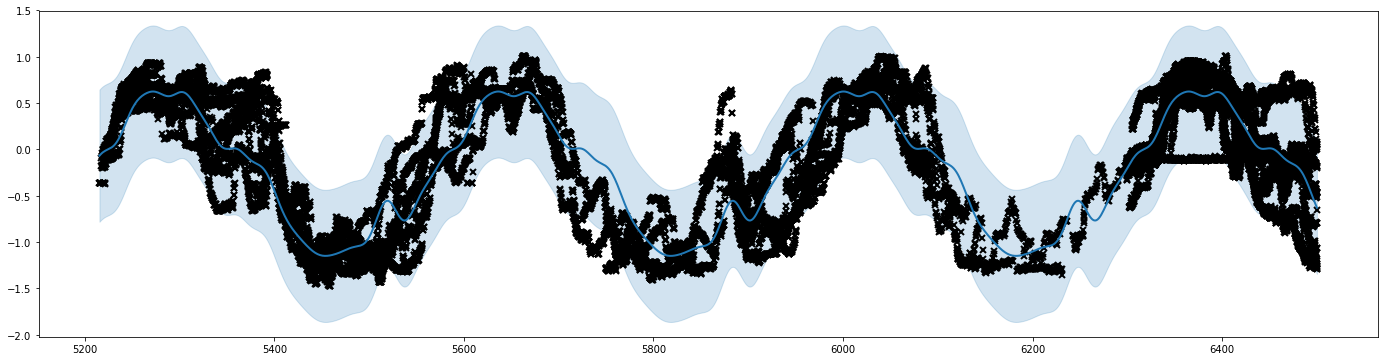

In [43]:

k1 = gpflow.kernels.Periodic(1,period=364.25, variance=10.0, lengthscales=100)
k1.period.trainable=False
M=500
Z = T1[::M, :].copy()
m = gpflow.models.SGPR(T1, X1, kern=k1,Z=Z)
m.likelihood.variance = 1.0
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
#plt.plot(X, Y, 'kx', mew=2)
m.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 30845.959899
  Number of iterations: 86
  Number of functions evaluations: 159


NameError: name 'm' is not defined

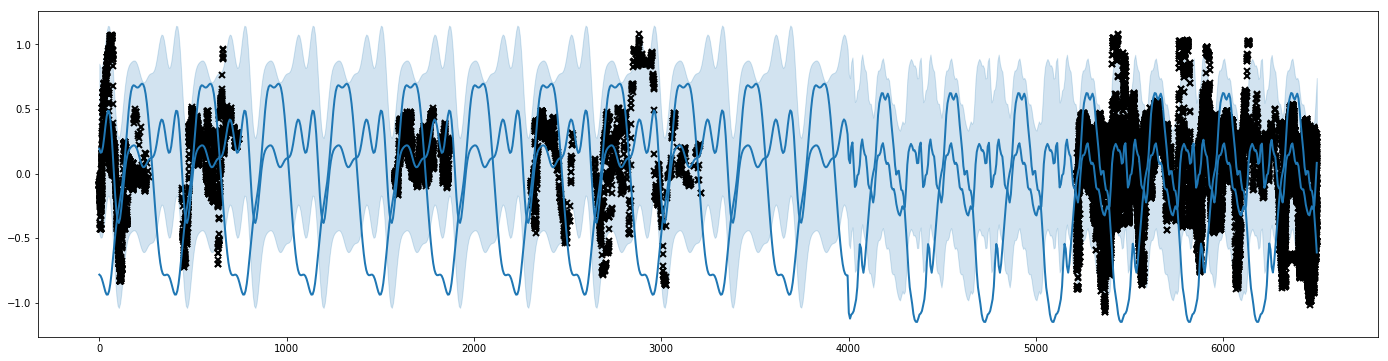

In [6]:
k1 = gpflow.kernels.Periodic(1,period=364.25, variance=10.0, lengthscales=100)
k1.period.trainable=False
k2 = gpflow.kernels.Periodic(1,period=364.25, variance=10.0, lengthscales=100)
k2.period.trainable=False
k=ChangePoint([k1,k2],offset=4000.0,variance=1.0)
M=500
Z = T1[::M, :].copy()
XY = np.hstack((Y1,X1))
mY = gpflow.models.SGPR(T1, XY, kern=k,Z=Z)
mY.likelihood.variance = 1.0
gpflow.train.ScipyOptimizer().minimize(mY)
xx = np.linspace(min(T1), max(T1), 1000).reshape(1000, 1)
mean, var = mY.predict_y(xx)
plt.figure(figsize=(24, 6))
plt.plot(T1, Y1, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 2*np.sqrt(var[:,0]),
                 mean[:,0] + 2*np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)
#plt.plot(X, Y, 'kx', mew=2)
m.as_pandas_table()

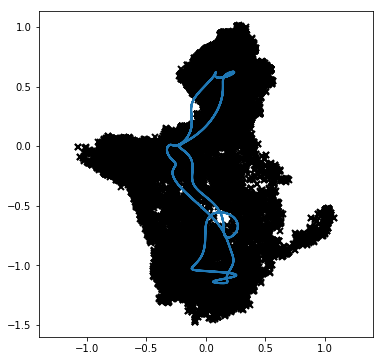

In [51]:
xx = np.linspace(min(T1), 4000, 1000).reshape(1000, 1)
meanY, varY = mY.predict_y(xx)
meanY, varY = mY.predict_y(xx)
plt.figure(figsize=(6, 6))
plt.plot(Y1, X1, 'kx', mew=2)
plt.plot(meanY, meanX, 'C0', lw=2)
plt.axis('equal')
plt.show()


#plt.fill_between(xx[:,0],
#                 mean[:,0] - 2*np.sqrt(var[:,0]),
#                 mean[:,0] + 2*np.sqrt(var[:,0]),
#                 color='C0', alpha=0.2)

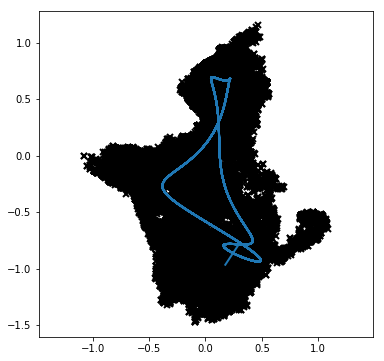

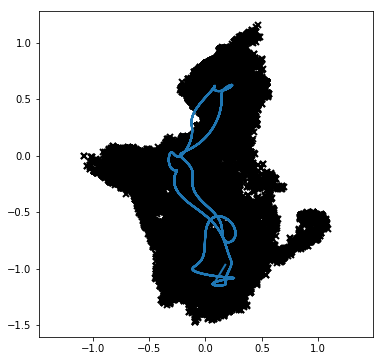

In [7]:
xx = np.linspace(min(T1), 4000, 1000).reshape(1000, 1)
meanY, varY = mY.predict_y(xx)
plt.figure(figsize=(6, 6))
plt.plot(Y1, X1, 'kx', mew=2)
plt.plot(meanY[:,0], meanY[:,1], 'C0', lw=2)
plt.axis('equal')
plt.show()
xx = np.linspace(4000, max(T1), 1000).reshape(1000, 1)
meanY, varY = mY.predict_y(xx)
plt.figure(figsize=(6, 6))
plt.plot(Y1, X1, 'kx', mew=2)
plt.plot(meanY[:,0], meanY[:,1], 'C0', lw=2)
plt.axis('equal')
plt.show()

In [10]:
from IPython.display import display, clear_output, HTML, Image
import numpy as np
image = np.random.rand(64, 16, 128)

import sys
import matplotlib.pyplot as plt
from matplotlib import animation, rc
animation.rcParams['animation.writer'] = 'html'

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))
plt.close()
ax.xlim = (0, image.shape[1])
ax.ylim = (0, image.shape[2])
ax.set_xticks([])
ax.set_yticks([])
img = ax.imshow(image[:, :, 0].T, cmap='gray')
img.set_interpolation('nearest')
def animate(i): 
    #img = ax.imshow(image[:, :, i].T, cmap='gray')
    img.set_data(image[:, :, i].T)
    #ax.xaxis.set_visible(False)
    #ax.yaxis.set_visible(False)
    clear_output(wait=True)
    print ('It: %i'%i)
    sys.stdout.flush()
    return (img,)
            
# call the animator. blit=True means only re-draw the parts that have changed.
# *interval* draws a new frame every *interval* milliseconds.
anim = animation.FuncAnimation(fig, animate, frames=image.shape[-1], interval=50, blit=True)
HTML(anim.to_html5_video()) 

It: 0


ValueError: outfile must be *.htm or *.html

In [54]:
XY = np.hstack((Y1,X1))
XY.shape

(40949, 2)

In [9]:
import matplotlib.animation as animation
print(animation.writers.list())

['html']
